<a href="https://colab.research.google.com/github/jahua/cv_colorization_Gan/blob/main/CV_coloring_RGB_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computer Vision project - Colorize Gray Image with GAN model**


Group 4 :    [	"Vignesh Govindaraj", 	"Ritu Raj Singh", 	" Duojie Jiahua"]


The ability to add color to grayscale images has many uses, from bringing old photos back to life to making modern pictures and videos better. GANs, which stands for Generative Adversarial Networks, are a strong way to do this. They can make colorized images that look very close to real life. By looking into how well GANs can do this, we can help make image processing and computer vision better.

**How it works**
Our GAN will have two main parts:
1. **Generator:** This part takes a black-and-white image and makes a color version of it.
2. **Discriminator:** This part looks at the color image the generator made and decides how real it looks compared to actual color photos.

The generator and discriminator learn by competing with each other. The generator tries to make images that the discriminator can't tell apart from real ones. The discriminator learns to spot the fake images. As they keep trying to beat each other, the generator gets better and better at making color images that look real.

**The data we'll use**
For this project, we'll use a set of images called CIFAR-10. It has 60,000 small color pictures (32x32 pixels) of things like planes, cars, and birds. We'll turn some of these into black-and-white images. This will give us a lot of different kinds of pictures to train our GAN with. Having so many types of objects and scenes in CIFAR-10 will help the GAN learn to add color to images in a way that looks right, no matter what's in the picture.

We used 10,000 images from batch_1 fron this image labrary for trainning, you can download and find details on link.
https://www.cs.toronto.edu/~kriz/cifar.html


# 1.  GAN Model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Created directories at: /content/drive/MyDrive/Colab Notebooks/cv
Loading CIFAR-10 data...
Converting to grayscale...
Normalizing data...
Processed 10000 images successfully

Epoch 1/5
  Step 0: Gen Loss: 0.6445, Disc Loss: 1.4059
  Step 100: Gen Loss: 0.0454, Disc Loss: 0.9577
  Step 200: Gen Loss: 0.0185, Disc Loss: 1.2730
  Step 300: Gen Loss: 0.0137, Disc Loss: 1.2769
Epoch 1 - Generator Loss: 0.0146, Discriminator Loss: 1.3134

Epoch 2/5
  Step 0: Gen Loss: 0.0146, Disc Loss: 1.3247
  Step 100: Gen Loss: 0.0117, Disc Loss: 1.2135
  Step 200: Gen Loss: 0.0133, Disc Loss: 1.0976
  Step 300: Gen Loss: 0.0111, Disc Loss: 0.9391
Epoch 2 - Generator Loss: 0.0115, Discriminator Loss: 1.0039

Epoch 3/5
  Step 0: Gen Loss: 0.0117, Disc Loss: 0.9483
  Step 100: Gen Loss: 0.0102, Disc Loss: 0.7693
  Step 200: Gen Loss: 0.0104, Disc Loss: 0.7527
  Step 300: Gen Loss

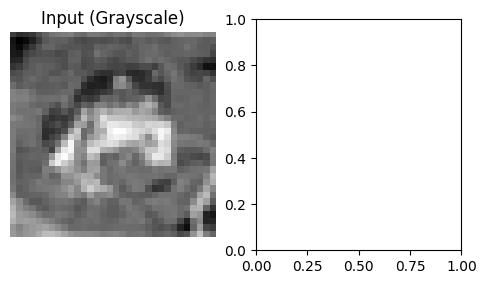

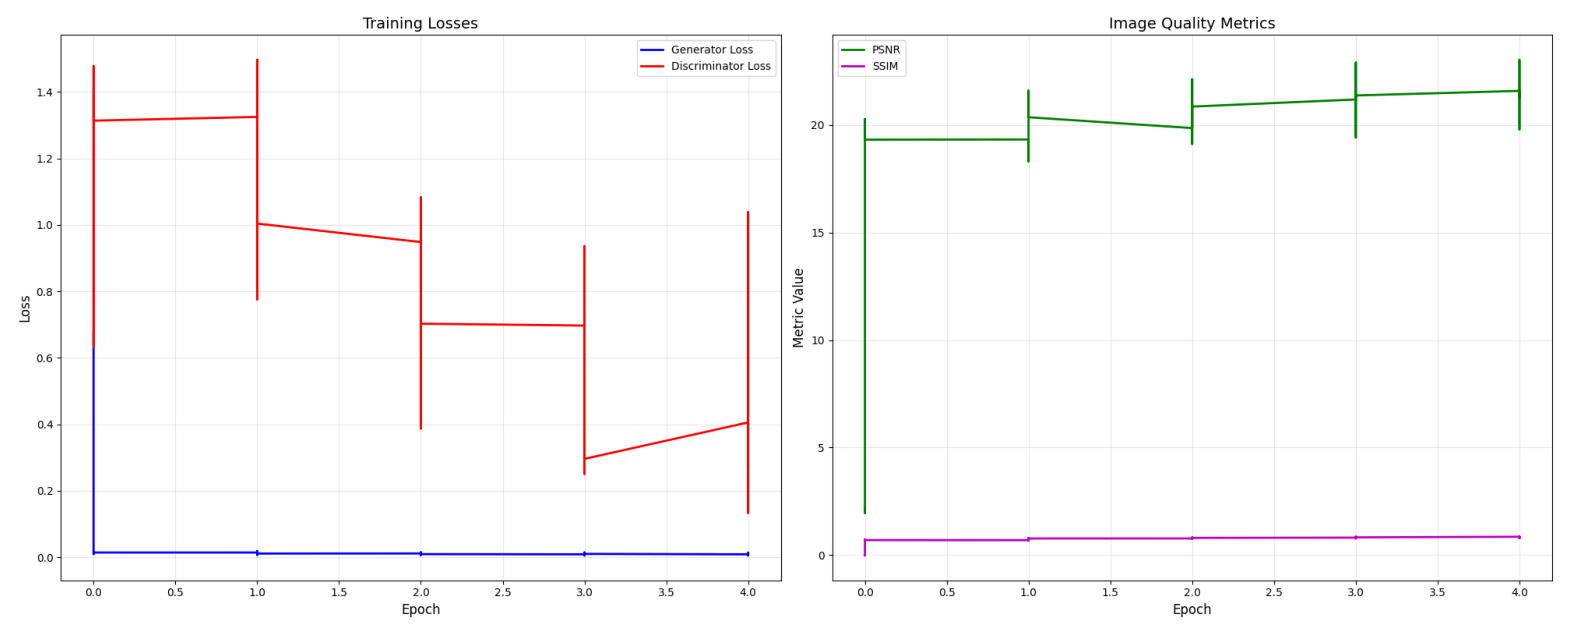

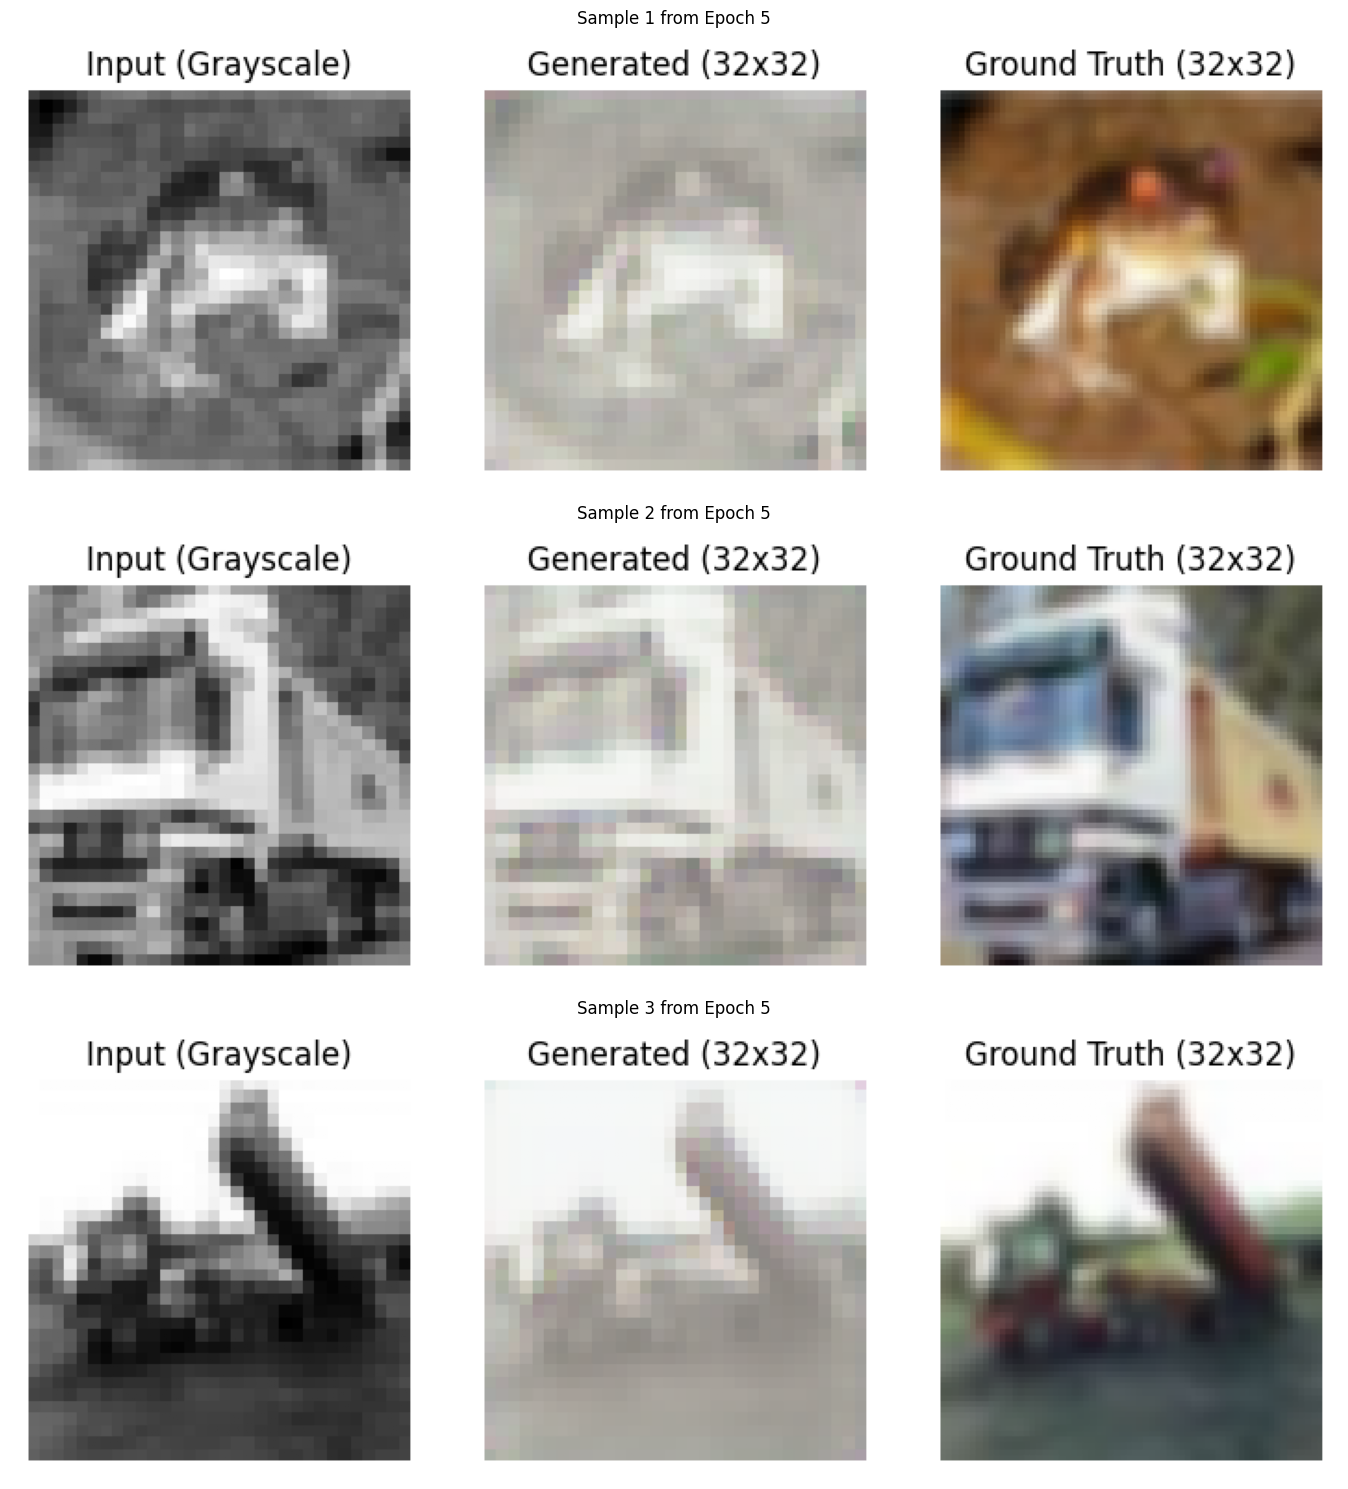

Training completed successfully!


In [59]:
# -*- coding: utf-8 -*-
"""
Image Colorization GAN
Author: Author: Group 4    [	"Vignesh Govindaraj", 	"Ritu Raj Singh", 	" Duojie Jiahua"]
Date: October 2024
Description: Converts grayscale images to RGB using GAN architecture
"""

# ================ 1. IMPORTS ================
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
import matplotlib.pyplot as plt
import os
import requests
import pandas as pd
from PIL import Image
from io import BytesIO
from google.colab import drive
from datetime import datetime
import json

# ================ 2. CONFIGURATION ================
class Config:
    def __init__(self):
        # Model parameters
        self.input_image_size = 32  # CIFAR-10 input size
        self.output_image_size = 32  # New output size
        self.batch_size = 32
        self.epochs = 5
        self.gen_lr = 1e-4
        self.disc_lr = 1e-4
        self.latent_dim = 128

        # Architecture
        self.gen_filters = [32, 64, 128]
        self.disc_filters = [32, 64, 128]
        self.use_batch_norm = True
        self.dropout_rate = 0.3

        # Paths
        self.base_path = '/content/drive/MyDrive/Colab Notebooks/cv'
        self.data_path = f'{self.base_path}/data'
        self.model_path = f'{self.base_path}/models'
        self.checkpoint_path = f'{self.base_path}/checkpoints'

        # Training
        self.save_interval = 5
        self.sample_size = 3

        # Visualization
        self.fig_size = (20, 8)
        self.dpi = 100
        self.cmap = 'gray'

# ================ 3. DATA HANDLER ================
class DataHandler:
    def __init__(self, config):
        self.config = config
        self.paths = self._prepare_directories()

    def _prepare_directories(self):
        """Creates necessary directories"""
        directories = {
            'base': self.config.base_path,
            'data': self.config.data_path,
            'gray': f'{self.config.base_path}/gray_images',
            'rgb': f'{self.config.base_path}/rgb_images',
            'models': self.config.model_path,
            'samples': f'{self.config.base_path}/samples',
            'metrics': f'{self.config.base_path}/metrics',
            'checkpoints': self.config.checkpoint_path
        }

        for dir_path in directories.values():
            os.makedirs(dir_path, exist_ok=True)

        print("Created directories at:", self.config.base_path)
        return directories

    def load_cifar10_batch(self, file):
        """Loads and processes CIFAR-10 data"""
        try:
            with open(file, 'rb') as fo:
                batch = pickle.load(fo, encoding='bytes')

            data = batch[b'data']
            labels = batch[b'labels']
            data = data.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float32")

            # Remove the resizing step since CIFAR-10 images are already 32x32
            return data, labels

        except Exception as e:
            print(f"Error loading CIFAR-10 data: {str(e)}")
            raise

    def rgb_to_grayscale(self, images):
        """Converts RGB images to grayscale"""
        return np.dot(images[...,:3], [0.2989, 0.5870, 0.1140])

    def process_data(self):
        """Main data processing pipeline"""
        try:
            data_file = f"{self.paths['data']}/data_batch_1"
            if not os.path.exists(data_file):
                raise FileNotFoundError(f"CIFAR-10 data not found at {data_file}")

            print("Loading CIFAR-10 data...")
            data, labels = self.load_cifar10_batch(data_file)

            print("Converting to grayscale...")
            gray_images = self.rgb_to_grayscale(data)
            gray_images = gray_images.reshape(gray_images.shape + (1,))

            print("Normalizing data...")
            data = tf.cast(data / 255.0, tf.float32)
            gray_images = tf.cast(gray_images / 255.0, tf.float32)

            print(f"Processed {len(data)} images successfully")
            return gray_images, data

        except Exception as e:
            print(f"Error processing data: {str(e)}")
            raise

# ================ 4. METRICS TRACKER ================
class MetricsTracker:
    def __init__(self, config):
        self.config = config
        self.metrics_path = f'{config.base_path}/metrics'
        os.makedirs(self.metrics_path, exist_ok=True)

        self.history = {
            'epoch': [],
            'gen_loss': [],
            'disc_loss': [],
            'psnr': [],
            'ssim': []
        }

        self.best_metrics = {
            'gen_loss': float('inf'),
            'psnr': float('-inf'),
            'ssim': float('-inf')
        }

    def update(self, epoch, gen_loss, disc_loss, generated_images, real_images):
        """Updates training metrics"""
        psnr = tf.reduce_mean(tf.image.psnr(real_images, generated_images, max_val=1.0))
        ssim = tf.reduce_mean(tf.image.ssim(real_images, generated_images, max_val=1.0))

        # Update history
        self.history['epoch'].append(epoch)
        self.history['gen_loss'].append(float(gen_loss))
        self.history['disc_loss'].append(float(disc_loss))
        self.history['psnr'].append(float(psnr))
        self.history['ssim'].append(float(ssim))

        # Update best metrics
        gen_loss_val = float(gen_loss)
        psnr_val = float(psnr)
        ssim_val = float(ssim)

        if gen_loss_val < self.best_metrics['gen_loss']:
            self.best_metrics['gen_loss'] = gen_loss_val
        if psnr_val > self.best_metrics['psnr']:
            self.best_metrics['psnr'] = psnr_val
        if ssim_val > self.best_metrics['ssim']:
            self.best_metrics['ssim'] = ssim_val

    def save_metrics(self):
        """Saves metrics and creates visualizations"""
        df = pd.DataFrame(self.history)
        metrics_file = f'{self.metrics_path}/training_metrics.csv'
        df.to_csv(metrics_file, index=False)
        print(f"Saved metrics to: {metrics_file}")

        # Save best metrics
        best_metrics_file = f'{self.metrics_path}/best_metrics.csv'
        pd.DataFrame([self.best_metrics]).to_csv(best_metrics_file, index=False)
        print(f"Saved best metrics to: {best_metrics_file}")

        # Create and save plots
        self.plot_metrics()

    def plot_metrics(self):
        """Creates and displays training plots"""
        df = pd.DataFrame(self.history)

        plt.figure(figsize=self.config.fig_size)

        # Plot losses
        plt.subplot(1, 2, 1)
        plt.plot(df['epoch'], df['gen_loss'], 'b-', label='Generator Loss', linewidth=2)
        plt.plot(df['epoch'], df['disc_loss'], 'r-', label='Discriminator Loss', linewidth=2)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.title('Training Losses', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=10)

        # Plot quality metrics
        plt.subplot(1, 2, 2)
        plt.plot(df['epoch'], df['psnr'], 'g-', label='PSNR', linewidth=2)
        plt.plot(df['epoch'], df['ssim'], 'm-', label='SSIM', linewidth=2)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Metric Value', fontsize=12)
        plt.title('Image Quality Metrics', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=10)

        plt.tight_layout()

        # Save the plot
        plot_file = f'{self.metrics_path}/training_summary.png'
        plt.savefig(plot_file, dpi=self.config.dpi, bbox_inches='tight')
        plt.close()
        print(f"Saved plots to: {plot_file}")

        # Display the plot in notebook
        img = plt.imread(plot_file)
        plt.figure(figsize=self.config.fig_size)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
# ================ 5. GAN MODEL ================
class GAN:
    def __init__(self, config):
        self.config = config
        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()
        self.gen_optimizer = tf.keras.optimizers.Adam(config.gen_lr)
        self.disc_optimizer = tf.keras.optimizers.Adam(config.disc_lr)
        self.cross_entropy = BinaryCrossentropy()
        self.mse = MeanSquaredError()

    def _build_generator(self):
        """Builds generator model"""
        inputs = tf.keras.layers.Input(shape=(self.config.input_image_size, self.config.input_image_size, 1))
        x = inputs

        # Encoder
        for filters in self.config.gen_filters:
            x = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same')(x)
            if self.config.use_batch_norm:
                x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.LeakyReLU()(x)
            if self.config.dropout_rate > 0:
                x = tf.keras.layers.Dropout(self.config.dropout_rate)(x)

        # Decoder
        (x)  # Upsample to 64x64
        for filters in reversed(self.config.gen_filters[:-1]):
            x = tf.keras.layers.Conv2DTranspose(filters, kernel_size=3, padding='same')(x)
            if self.config.use_batch_norm:
                x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.LeakyReLU()(x)

        outputs = tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='tanh')(x)
        return tf.keras.Model(inputs=inputs, outputs=outputs)

    def _build_discriminator(self):
        """Builds discriminator model"""
        model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(self.config.input_image_size, self.config.input_image_size, 3)),
            tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(self.config.dropout_rate),

            tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(self.config.dropout_rate),

            tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(self.config.dropout_rate),

            tf.keras.layers.Conv2D(256, kernel_size=3, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Dropout(self.config.dropout_rate),

            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        return model

    def discriminator_loss(self, real_output, fake_output):
        """Calculates discriminator loss"""
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    def save_models(self, base_path, epoch):
        """Saves both models"""
        self.generator.save(f'{base_path}/generator_epoch_{epoch}.keras')
        self.discriminator.save(f'{base_path}/discriminator_epoch_{epoch}.keras')

# ================ 6. TRAINER ================
class Trainer:
    def __init__(self, gan, config):
        self.gan = gan
        self.config = config
        self.metrics = MetricsTracker(config)

    @tf.function
    def train_step(self, gray_images, real_images):
        """Performs a single training step"""
        gray_images = tf.cast(gray_images, tf.float32)
        real_images = tf.cast(real_images, tf.float32)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.gan.generator(gray_images, training=True)

            real_output = self.gan.discriminator(real_images, training=True)
            fake_output = self.gan.discriminator(generated_images, training=True)

            gen_loss = self.gan.mse(real_images, generated_images)
            disc_loss = self.gan.discriminator_loss(real_output, fake_output)

        gen_gradients = gen_tape.gradient(gen_loss, self.gan.generator.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.gan.discriminator.trainable_variables)

        self.gan.gen_optimizer.apply_gradients(zip(gen_gradients, self.gan.generator.trainable_variables))
        self.gan.disc_optimizer.apply_gradients(zip(disc_gradients, self.gan.discriminator.trainable_variables))

        return gen_loss, disc_loss, generated_images

    def _save_progress(self, epoch, gray_images, rgb_images):
        """Saves training progress images"""
        try:
            # Convert tensors to numpy arrays
            gray_samples = gray_images[:self.config.sample_size].numpy()
            rgb_samples = rgb_images[:self.config.sample_size].numpy()

            # Generate new samples
            generated_samples = self.gan.generator.predict(gray_samples)

            # Save sample images
            for i in range(self.config.sample_size):
                plt.figure(figsize=(9, 3))  # Adjusted figure size for better visibility

                # Plot grayscale input
                plt.subplot(1, 3, 1)
                plt.imshow(np.squeeze(gray_samples[i]), cmap='gray')
                plt.title('Input (Grayscale)')
                plt.axis('off')

                # Plot generated image
                plt.subplot(1, 3, 2)
                # Resize generated image to 32x32
                resized_generated = tf.image.resize(generated_samples[i], (128, )).numpy()
                plt.imshow(np.clip((resized_generated + 1) * 0.5, 0, 1))
                plt.title('Generated (32x32)')
                plt.axis('off')

                # Plot ground truth (resized to 32x32)
                plt.subplot(1, 3, 3)
                resized_rgb = tf.image.resize(rgb_samples[i], (64, 64)).numpy()
                plt.imshow(resized_rgb)
                plt.title('Ground Truth (32x32)')
                plt.axis('off')

                # Save figure
                save_path = f'{self.config.base_path}/samples/epoch_{epoch+1}_sample_{i}.png'
                plt.savefig(save_path, dpi=self.config.dpi, bbox_inches='tight', pad_inches=0.1)
                plt.close()

            # Save models
            self.gan.save_models(self.config.model_path, epoch)
            print(f"Saved progress images and models for epoch {epoch+1}")

        except Exception as e:
            print(f"Error saving progress: {str(e)}")

    def train(self, dataset, gray_images, rgb_images):
        """Runs the training loop"""
        for epoch in range(self.config.epochs):
            print(f'\nEpoch {epoch + 1}/{self.config.epochs}')

            for step, (batch_gray, batch_rgb) in enumerate(dataset):
                gen_loss, disc_loss, generated_images = self.train_step(batch_gray, batch_rgb)

                if step % 100 == 0:
                    print(f'  Step {step}: Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}')

                self.metrics.update(epoch, gen_loss, disc_loss, generated_images, batch_rgb)

            print(f'Epoch {epoch + 1} - Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}')

            if (epoch + 1) % self.config.save_interval == 0:
                self._save_progress(epoch, gray_images, rgb_images)

        # Save final metrics and create visualizations
        self.metrics.save_metrics()

# ================ 7. VISUALIZATION ================
def plot_sample_results(samples_dir=None, epoch=None):
    """Plots sample results from training"""
    if samples_dir is None:
        samples_dir = '/content/drive/MyDrive/Colab Notebooks/cv/samples'

    if epoch is None:
        # Get the latest epoch
        samples = [f for f in os.listdir(samples_dir) if f.endswith('.png')]
        if not samples:
            print("No samples found.")
            return
        epoch = max([int(f.split('_')[1]) for f in samples if '_' in f])

    plt.figure(figsize=(15, 5 * 3))
    for i in range(3):
        img_path = f'{samples_dir}/epoch_{epoch}_sample_{i}.png'
        if os.path.exists(img_path):
            img = plt.imread(img_path)
            plt.subplot(3, 1, i+1)
            plt.imshow(img)
            plt.title(f'Sample {i+1} from Epoch {epoch}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# ================ 8. MAIN EXECUTION ================
def main():
    try:
        # Initialize configuration
        config = Config()

        # Initialize data handler and load data
        data_handler = DataHandler(config)
        gray_images, rgb_images = data_handler.process_data()

        # Create dataset
        dataset = tf.data.Dataset.from_tensor_slices((
            tf.cast(gray_images, tf.float32),
            tf.cast(rgb_images, tf.float32)
        ))
        dataset = dataset.batch(config.batch_size).shuffle(buffer_size=1000)

        # Initialize GAN
        gan = GAN(config)

        # Train model
        trainer = Trainer(gan, config)
        trainer.train(dataset, gray_images, rgb_images)

        # Plot final results
        plot_sample_results()

        print("Training completed successfully!")

    except Exception as e:
        print(f"Error during execution: {str(e)}")
        raise

if __name__ == "__main__":
    # Mount Google Drive
    drive.mount('/content/drive')
    main()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


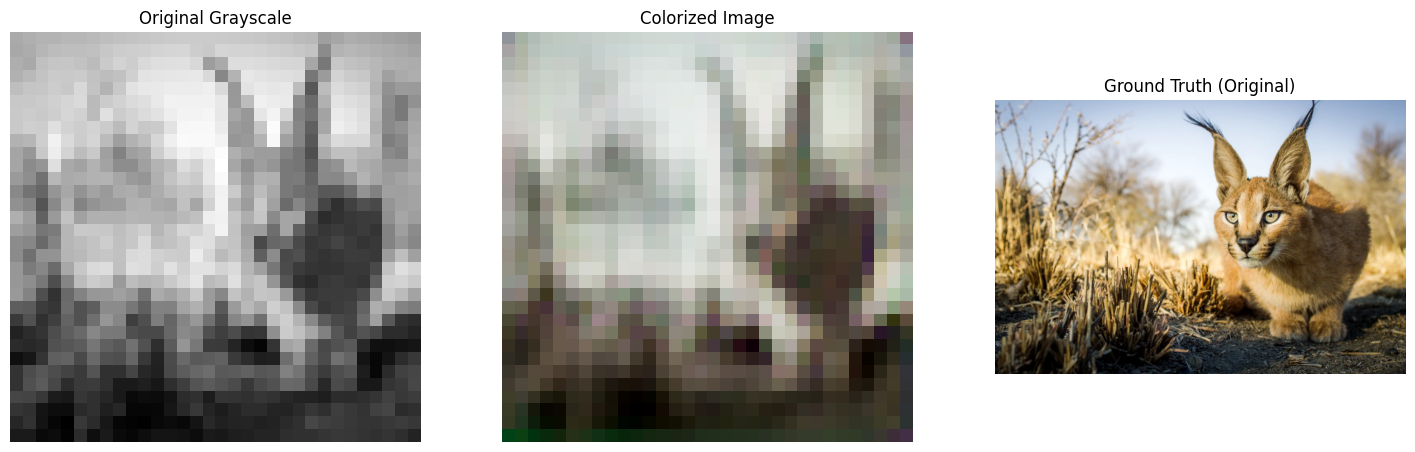

In [54]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# URL of the image
image_url = "https://c02.purpledshub.com/uploads/sites/62/2019/01/Cat-c6f5a79.jpg?w=1880&webp=1"

# Function to load and preprocess the image for model input
def load_and_preprocess_image(image_url, target_size=(32, 32)):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    image = image.resize(target_size)
    image = image.convert('L')  # Convert to grayscale
    image = np.array(image)
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to load the original image without resizing or converting to grayscale
def load_original_image(image_url):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    return image

# Load the grayscale image for model input
input_image = load_and_preprocess_image(image_url)

# Load the original image
original_image = load_original_image(image_url)

# Load the pre-trained model
model_path = '/content/drive/MyDrive/Colab Notebooks/cv/models/generator_epoch_4.keras'  # Adjust path as necessary
model = tf.keras.models.load_model(model_path)

# Predict the colorized image
predicted = model.predict(input_image)
predicted_image = np.clip(predicted[0], 0, 1)  # Clip values to valid range

# Plot the results
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(input_image[0]), cmap='gray')
plt.title('Original Grayscale')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predicted_image)
plt.title('Colorized Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(original_image)
plt.title('Ground Truth (Original)')
plt.axis('off')

plt.show()

# 2. Improved GAN Model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Created directories at: /content/drive/MyDrive/Colab Notebooks/cv
Loading CIFAR-10 data...
Converting to grayscale...
Normalizing data...
Processed 10000 images successfully

Epoch 1/100
  Step 0: Gen Loss: 0.5000, Disc Loss: 1.3899
  Step 100: Gen Loss: 0.0105, Disc Loss: 1.3555
  Step 200: Gen Loss: 0.0092, Disc Loss: 1.2142
  Step 300: Gen Loss: 0.0127, Disc Loss: 0.7683
Epoch 1 - Generator Loss: 0.0094, Discriminator Loss: 0.6474

Epoch 2/100
  Step 0: Gen Loss: 0.0089, Disc Loss: 0.6933
  Step 100: Gen Loss: 0.0084, Disc Loss: 0.5959
  Step 200: Gen Loss: 0.0053, Disc Loss: 0.7242
  Step 300: Gen Loss: 0.0060, Disc Loss: 0.3792
Epoch 2 - Generator Loss: 0.0068, Discriminator Loss: 0.3122

Epoch 3/100
  Step 0: Gen Loss: 0.0046, Disc Loss: 0.4007
  Step 100: Gen Loss: 0.0066, Disc Loss: 0.6037
  Step 200: Gen Loss: 0.0063, Disc Loss: 0.1866
  Step 300: Ge

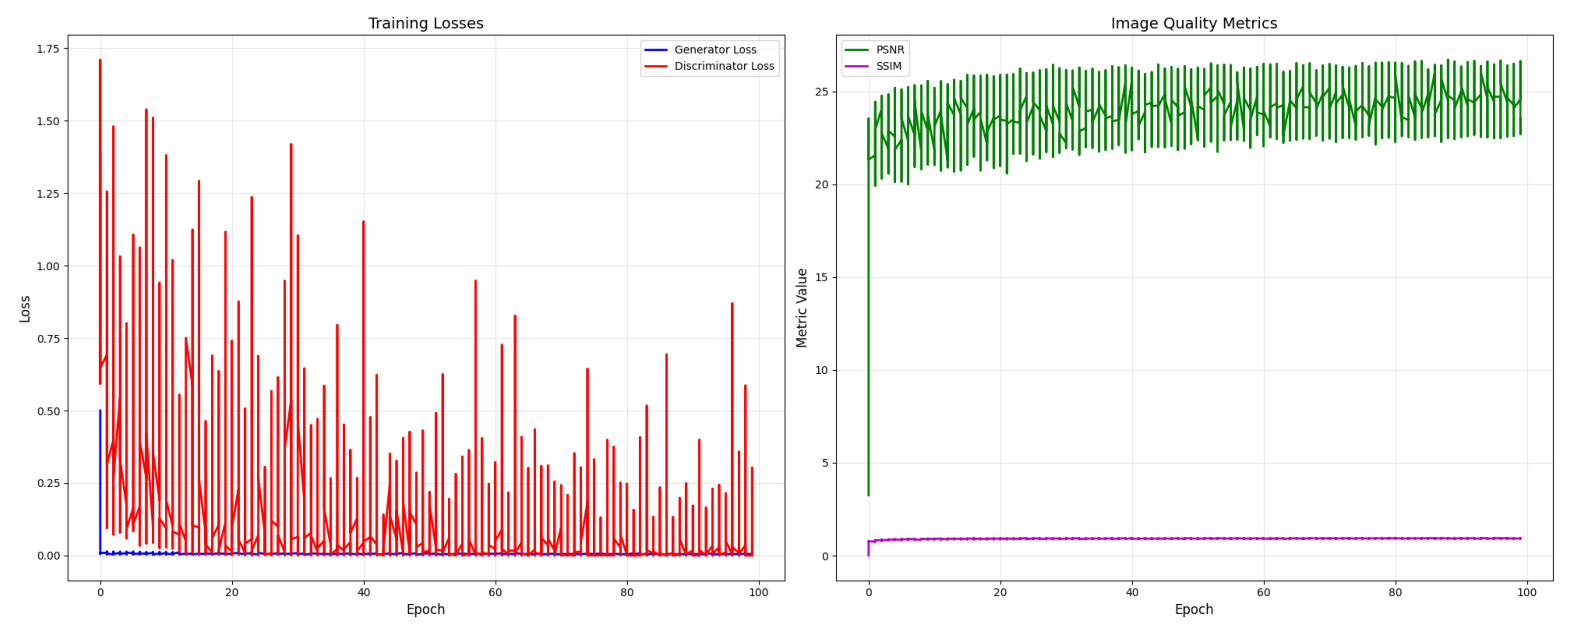

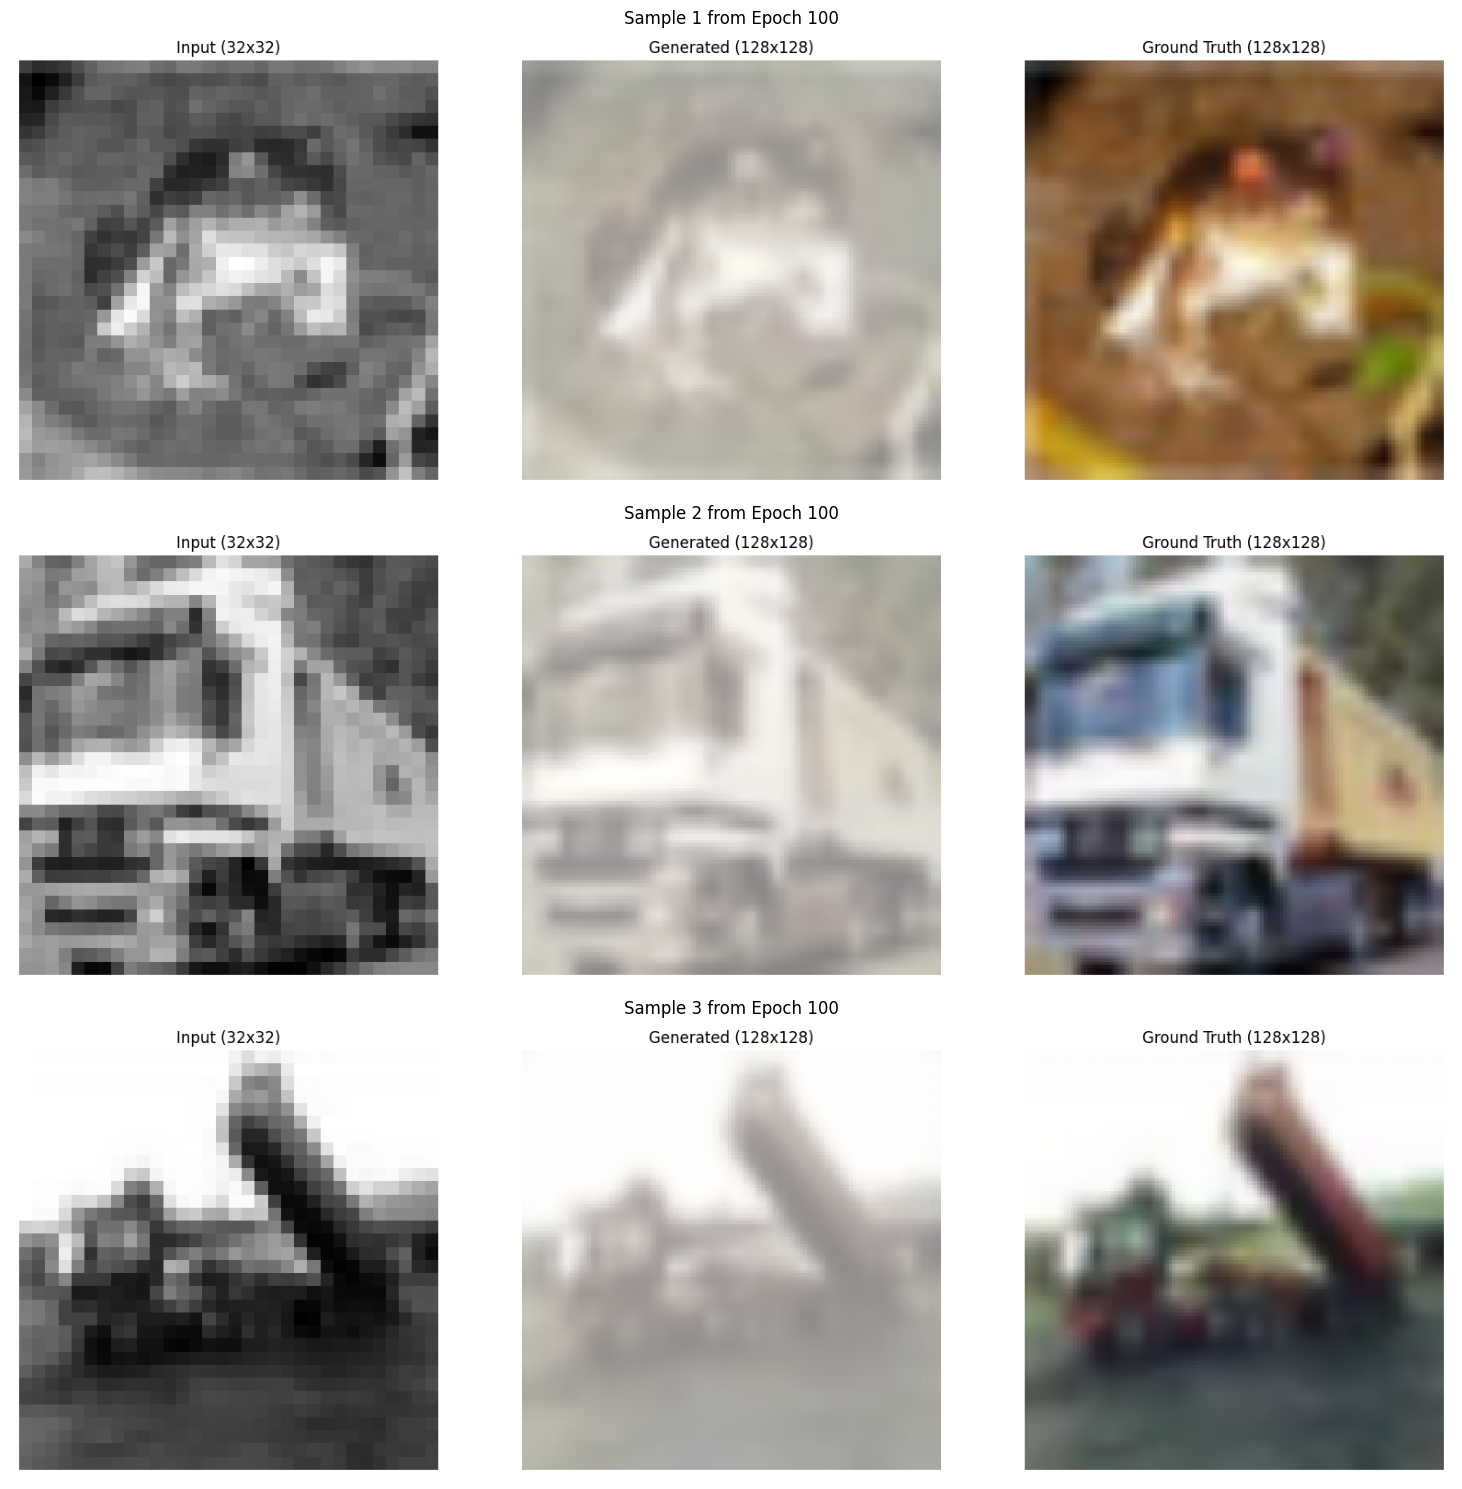

Training completed successfully!


In [60]:
# -*- coding: utf-8 -*-
"""
Image Colorization GAN
Author: Group 4    [	"Vignesh Govindaraj", 	"Ritu Raj Singh", 	" Duojie Jiahua"]
Date: October 2024
Description: Converts grayscale images (32x32) to RGB (128x128) using GAN architecture
"""

# ================ 1. IMPORTS ================
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
import matplotlib.pyplot as plt
import os
import requests
import pandas as pd
from PIL import Image
from io import BytesIO
from google.colab import drive
from datetime import datetime
import json

# ================ 2. CONFIGURATION ================
class Config:
    def __init__(self):
        # Model parameters
        self.input_image_size = 32  # Input size for training
        self.output_image_size = 128  # Output size after upsampling
        self.batch_size = 32
        self.epochs = 100
        self.gen_lr = 1e-4
        self.disc_lr = 1e-4
        self.latent_dim = 128

        # Architecture
        self.gen_filters = [64, 128, 256, 512]  # Increased filters for upsampling
        self.disc_filters = [64, 128, 256, 512]
        self.use_batch_norm = True
        self.dropout_rate = 0.3

        # Paths
        self.base_path = '/content/drive/MyDrive/Colab Notebooks/cv'
        self.data_path = f'{self.base_path}/data'
        self.model_path = f'{self.base_path}/models'
        self.checkpoint_path = f'{self.base_path}/checkpoints'

        # Training
        self.save_interval = 5
        self.sample_size = 3

        # Visualization
        self.fig_size = (20, 8)
        self.dpi = 100
        self.cmap = 'gray'

# ================ 3. DATA HANDLER ================
class DataHandler:
    def __init__(self, config):
        self.config = config
        self.paths = self._prepare_directories()

    def _prepare_directories(self):
        """Creates necessary directories"""
        directories = {
            'base': self.config.base_path,
            'data': self.config.data_path,
            'gray': f'{self.config.base_path}/gray_images',
            'rgb': f'{self.config.base_path}/rgb_images',
            'models': self.config.model_path,
            'samples': f'{self.config.base_path}/samples',
            'metrics': f'{self.config.base_path}/metrics',
            'checkpoints': self.config.checkpoint_path
        }

        for dir_path in directories.values():
            os.makedirs(dir_path, exist_ok=True)

        print("Created directories at:", self.config.base_path)
        return directories

    def load_cifar10_batch(self, file):
        """Loads and processes CIFAR-10 data"""
        try:
            with open(file, 'rb') as fo:
                batch = pickle.load(fo, encoding='bytes')

            data = batch[b'data']
            labels = batch[b'labels']
            # CIFAR-10 images are already 32x32
            data = data.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float32")
            return data, labels

        except Exception as e:
            print(f"Error loading CIFAR-10 data: {str(e)}")
            raise

    def rgb_to_grayscale(self, images):
        """Converts RGB images to grayscale"""
        return np.dot(images[...,:3], [0.2989, 0.5870, 0.1140])

    def process_data(self):
        """Main data processing pipeline"""
        try:
            data_file = f"{self.paths['data']}/data_batch_1"
            if not os.path.exists(data_file):
                raise FileNotFoundError(f"CIFAR-10 data not found at {data_file}")

            print("Loading CIFAR-10 data...")
            data, labels = self.load_cifar10_batch(data_file)

            print("Converting to grayscale...")
            gray_images = self.rgb_to_grayscale(data)
            gray_images = gray_images.reshape(gray_images.shape + (1,))

            print("Normalizing data...")
            data = tf.cast(data / 255.0, tf.float32)
            gray_images = tf.cast(gray_images / 255.0, tf.float32)

            print(f"Processed {len(data)} images successfully")
            return gray_images, data

        except Exception as e:
            print(f"Error processing data: {str(e)}")
            raise

# ================ 4. METRICS TRACKER ================
class MetricsTracker:
    def __init__(self, config):
        self.config = config
        self.metrics_path = f'{config.base_path}/metrics'
        os.makedirs(self.metrics_path, exist_ok=True)

        self.history = {
            'epoch': [],
            'gen_loss': [],
            'disc_loss': [],
            'psnr': [],
            'ssim': []
        }

        self.best_metrics = {
            'gen_loss': float('inf'),
            'psnr': float('-inf'),
            'ssim': float('-inf')
        }

    def update(self, epoch, gen_loss, disc_loss, generated_images, real_images):
        """Updates training metrics"""
        # Resize real images to match generated size for metrics
        real_images_resized = tf.image.resize(real_images,
                                            (self.config.output_image_size,
                                             self.config.output_image_size))

        psnr = tf.reduce_mean(tf.image.psnr(real_images_resized, generated_images, max_val=1.0))
        ssim = tf.reduce_mean(tf.image.ssim(real_images_resized, generated_images, max_val=1.0))

        # Update history
        self.history['epoch'].append(epoch)
        self.history['gen_loss'].append(float(gen_loss))
        self.history['disc_loss'].append(float(disc_loss))
        self.history['psnr'].append(float(psnr))
        self.history['ssim'].append(float(ssim))

        # Update best metrics
        gen_loss_val = float(gen_loss)
        psnr_val = float(psnr)
        ssim_val = float(ssim)

        if gen_loss_val < self.best_metrics['gen_loss']:
            self.best_metrics['gen_loss'] = gen_loss_val
        if psnr_val > self.best_metrics['psnr']:
            self.best_metrics['psnr'] = psnr_val
        if ssim_val > self.best_metrics['ssim']:
            self.best_metrics['ssim'] = ssim_val

    def save_metrics(self):
        """Saves metrics and creates visualizations"""
        df = pd.DataFrame(self.history)
        metrics_file = f'{self.metrics_path}/training_metrics.csv'
        df.to_csv(metrics_file, index=False)
        print(f"Saved metrics to: {metrics_file}")

        best_metrics_file = f'{self.metrics_path}/best_metrics.csv'
        pd.DataFrame([self.best_metrics]).to_csv(best_metrics_file, index=False)
        print(f"Saved best metrics to: {best_metrics_file}")

        self.plot_metrics()

    def plot_metrics(self):
        """Creates and displays training plots"""
        df = pd.DataFrame(self.history)

        plt.figure(figsize=self.config.fig_size)

        # Plot losses
        plt.subplot(1, 2, 1)
        plt.plot(df['epoch'], df['gen_loss'], 'b-', label='Generator Loss', linewidth=2)
        plt.plot(df['epoch'], df['disc_loss'], 'r-', label='Discriminator Loss', linewidth=2)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.title('Training Losses', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=10)

        # Plot quality metrics
        plt.subplot(1, 2, 2)
        plt.plot(df['epoch'], df['psnr'], 'g-', label='PSNR', linewidth=2)
        plt.plot(df['epoch'], df['ssim'], 'm-', label='SSIM', linewidth=2)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Metric Value', fontsize=12)
        plt.title('Image Quality Metrics', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=10)

        plt.tight_layout()

        # Save the plot
        plot_file = f'{self.metrics_path}/training_summary.png'
        plt.savefig(plot_file, dpi=self.config.dpi, bbox_inches='tight')
        plt.close()
        print(f"Saved plots to: {plot_file}")

        # Display the plot in notebook
        img = plt.imread(plot_file)
        plt.figure(figsize=self.config.fig_size)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
# ================ 5. GAN MODEL ================
class GAN:
    def __init__(self, config):
        self.config = config
        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()
        self.gen_optimizer = tf.keras.optimizers.Adam(config.gen_lr)
        self.disc_optimizer = tf.keras.optimizers.Adam(config.disc_lr)
        self.cross_entropy = BinaryCrossentropy()
        self.mse = MeanSquaredError()

    def _build_generator(self):
        """Builds generator model that upsamples from 32x32 to 128x128"""
        inputs = tf.keras.layers.Input(shape=(self.config.input_image_size,
                                            self.config.input_image_size, 1))

        # Initial processing
        x = inputs
        skips = []

        # Encoder path with skip connections
        for filters in self.config.gen_filters:
            x = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same')(x)
            if self.config.use_batch_norm:
                x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.LeakyReLU(0.2)(x)
            skips.append(x)

            if self.config.dropout_rate > 0:
                x = tf.keras.layers.Dropout(self.config.dropout_rate)(x)

        # First upsampling block (32->64)
        x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
        x = tf.keras.layers.Conv2D(256, kernel_size=3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)

        # Second upsampling block (64->128)
        x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
        x = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)

        # Final processing at 128x128
        x = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)

        # Output layer
        outputs = tf.keras.layers.Conv2D(3, kernel_size=3, padding='same',
                                       activation='tanh')(x)

        return tf.keras.Model(inputs=inputs, outputs=outputs)

    def _build_discriminator(self):
        """Builds discriminator model that handles 128x128 images"""
        return tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(self.config.output_image_size,
                                                  self.config.output_image_size, 3)),

            # First conv block (128->64)
            tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(0.2),
            tf.keras.layers.Dropout(self.config.dropout_rate),

            # Second conv block (64->32)
            tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(0.2),
            tf.keras.layers.Dropout(self.config.dropout_rate),

            # Third conv block (32->16)
            tf.keras.layers.Conv2D(256, kernel_size=3, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(0.2),
            tf.keras.layers.Dropout(self.config.dropout_rate),

            # Fourth conv block (16->8)
            tf.keras.layers.Conv2D(512, kernel_size=3, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(0.2),
            tf.keras.layers.Dropout(self.config.dropout_rate),

            # Output
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    def discriminator_loss(self, real_output, fake_output):
        """Calculates discriminator loss"""
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    def save_models(self, base_path, epoch):
        """Saves both models"""
        self.generator.save(f'{base_path}/generator_epoch_{epoch}.keras')
        self.discriminator.save(f'{base_path}/discriminator_epoch_{epoch}.keras')

# ================ 6. TRAINER ================
class Trainer:
    def __init__(self, gan, config):
        self.gan = gan
        self.config = config
        self.metrics = MetricsTracker(config)

    @tf.function
    def train_step(self, gray_images, real_images):
        """Performs a single training step"""
        gray_images = tf.cast(gray_images, tf.float32)
        real_images = tf.cast(real_images, tf.float32)

        # Resize real images to match generator output size
        real_images_resized = tf.image.resize(real_images,
                                            (self.config.output_image_size,
                                             self.config.output_image_size))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generate fake images
            generated_images = self.gan.generator(gray_images, training=True)

            # Discriminator predictions
            real_output = self.gan.discriminator(real_images_resized, training=True)
            fake_output = self.gan.discriminator(generated_images, training=True)

            # Calculate losses
            gen_loss = self.gan.mse(real_images_resized, generated_images)
            disc_loss = self.gan.discriminator_loss(real_output, fake_output)

        # Calculate gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gan.generator.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.gan.discriminator.trainable_variables)

        # Apply gradients
        self.gan.gen_optimizer.apply_gradients(zip(gen_gradients, self.gan.generator.trainable_variables))
        self.gan.disc_optimizer.apply_gradients(zip(disc_gradients, self.gan.discriminator.trainable_variables))

        return gen_loss, disc_loss, generated_images

    def _save_progress(self, epoch, gray_images, rgb_images):
        """Saves training progress images"""
        try:
            # Convert tensors to numpy arrays
            gray_samples = gray_images[:self.config.sample_size].numpy()
            rgb_samples = rgb_images[:self.config.sample_size].numpy()

            # Generate new samples
            generated_samples = self.gan.generator.predict(gray_samples)

            # Save sample images
            for i in range(self.config.sample_size):
                plt.figure(figsize=self.config.fig_size)

                # Plot grayscale input (32x32)
                plt.subplot(1, 3, 1)
                plt.imshow(np.squeeze(gray_samples[i]), cmap='gray')
                plt.title('Input (32x32)')
                plt.axis('off')

                # Plot generated image (128x128)
                plt.subplot(1, 3, 2)
                plt.imshow(np.clip((generated_samples[i] + 1) * 0.5, 0, 1))
                plt.title('Generated (128x128)')
                plt.axis('off')

                # Plot ground truth (resized to 128x128)
                plt.subplot(1, 3, 3)
                resized_rgb = tf.image.resize(rgb_samples[i],
                                            (self.config.output_image_size,
                                             self.config.output_image_size)).numpy()
                plt.imshow(resized_rgb)
                plt.title('Ground Truth (128x128)')
                plt.axis('off')

                # Save figure
                save_path = f'{self.config.base_path}/samples/epoch_{epoch+1}_sample_{i}.png'
                plt.savefig(save_path, dpi=self.config.dpi, bbox_inches='tight', pad_inches=0.1)
                plt.close()

            # Save models
            self.gan.save_models(self.config.model_path, epoch)
            print(f"Saved progress images and models for epoch {epoch+1}")

        except Exception as e:
            print(f"Error saving progress: {str(e)}")

    def train(self, dataset, gray_images, rgb_images):
        """Runs the training loop"""
        for epoch in range(self.config.epochs):
            print(f'\nEpoch {epoch + 1}/{self.config.epochs}')

            for step, (batch_gray, batch_rgb) in enumerate(dataset):
                gen_loss, disc_loss, generated_images = self.train_step(batch_gray, batch_rgb)

                if step % 100 == 0:
                    print(f'  Step {step}: Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}')

                self.metrics.update(epoch, gen_loss, disc_loss, generated_images, batch_rgb)

            print(f'Epoch {epoch + 1} - Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}')

            if (epoch + 1) % self.config.save_interval == 0:
                self._save_progress(epoch, gray_images, rgb_images)

        # Save final metrics and create visualizations
        self.metrics.save_metrics()

# I'll continue with Part 3 (Main execution and visualization) in the next response. Would you like me to proceed?

# ================ 7. VISUALIZATION ================
def plot_sample_results(samples_dir=None, epoch=None):
    """Plots sample results from training"""
    if samples_dir is None:
        samples_dir = '/content/drive/MyDrive/Colab Notebooks/cv/samples'

    if epoch is None:
        # Get the latest epoch
        samples = [f for f in os.listdir(samples_dir) if f.endswith('.png')]
        if not samples:
            print("No samples found.")
            return
        epoch = max([int(f.split('_')[1]) for f in samples if '_' in f])

    plt.figure(figsize=(15, 5 * 3))
    for i in range(3):
        img_path = f'{samples_dir}/epoch_{epoch}_sample_{i}.png'
        if os.path.exists(img_path):
            img = plt.imread(img_path)
            plt.subplot(3, 1, i+1)
            plt.imshow(img)
            plt.title(f'Sample {i+1} from Epoch {epoch}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# ================ 8. MAIN EXECUTION ================
def main():
    try:
        # Initialize configuration
        config = Config()

        # Initialize data handler and load data
        data_handler = DataHandler(config)
        gray_images, rgb_images = data_handler.process_data()

        # Create dataset
        dataset = tf.data.Dataset.from_tensor_slices((
            tf.cast(gray_images, tf.float32),
            tf.cast(rgb_images, tf.float32)
        ))
        dataset = dataset.batch(config.batch_size).shuffle(buffer_size=1000)

        # Initialize GAN
        gan = GAN(config)

        # Train model
        trainer = Trainer(gan, config)
        trainer.train(dataset, gray_images, rgb_images)

        # Plot final results
        plot_sample_results()

        print("Training completed successfully!")

    except Exception as e:
        print(f"Error during execution: {str(e)}")
        raise

# ================ 9. INFERENCE ================
def colorize_image(url, model_path):
    """Colorize a single image using trained model"""
    try:
        # Download image
        response = requests.get(url)
        original_img = Image.open(BytesIO(response.content))

        # Convert to grayscale and resize to 32x32 for model input
        gray_img = original_img.convert('L')
        gray_img_32 = gray_img.resize((32, 32), Image.Resampling.LANCZOS)

        # Convert to numpy array and normalize
        gray_array = np.array(gray_img_32)
        gray_input = (gray_array / 127.5) - 1
        gray_input = gray_input.reshape(1, 32, 32, 1)

        # Load model
        generator = tf.keras.models.load_model(model_path)

        # Generate colorized image
        colored = generator.predict(gray_input)

        # Denormalize and clip values
        colored = (colored[0] * 0.5 + 0.5)
        colored = np.clip(colored, 0, 1)

        # Display results
        plt.figure(figsize=(20, 7))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(original_img)
        plt.title('Original')
        plt.axis('off')

        # Grayscale input
        plt.subplot(1, 3, 2)
        plt.imshow(gray_img, cmap='gray')
        plt.title('Grayscale Input')
        plt.axis('off')

        # Colorized output (128x128)
        plt.subplot(1, 3, 3)
        plt.imshow(colored)
        plt.title('Colorized (128x128)')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        return colored

    except Exception as e:
        print(f"Error in colorization: {str(e)}")
        return None

def batch_colorize(image_urls, model_path):
    """Colorize multiple images using trained model"""
    colorized_images = []
    for url in image_urls:
        colored = colorize_image(url, model_path)
        if colored is not None:
            colorized_images.append(colored)
    return colorized_images

if __name__ == "__main__":
    # Mount Google Drive
    drive.mount('/content/drive')

    # Run training
    main()

    # Example usage for inference:
    # image_url = "https://example.com/grayscale_image.jpg"
    # model_path = '/content/drive/MyDrive/Colab Notebooks/cv/models/generator_final.keras'
    # colorized = colorize_image(image_url, model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


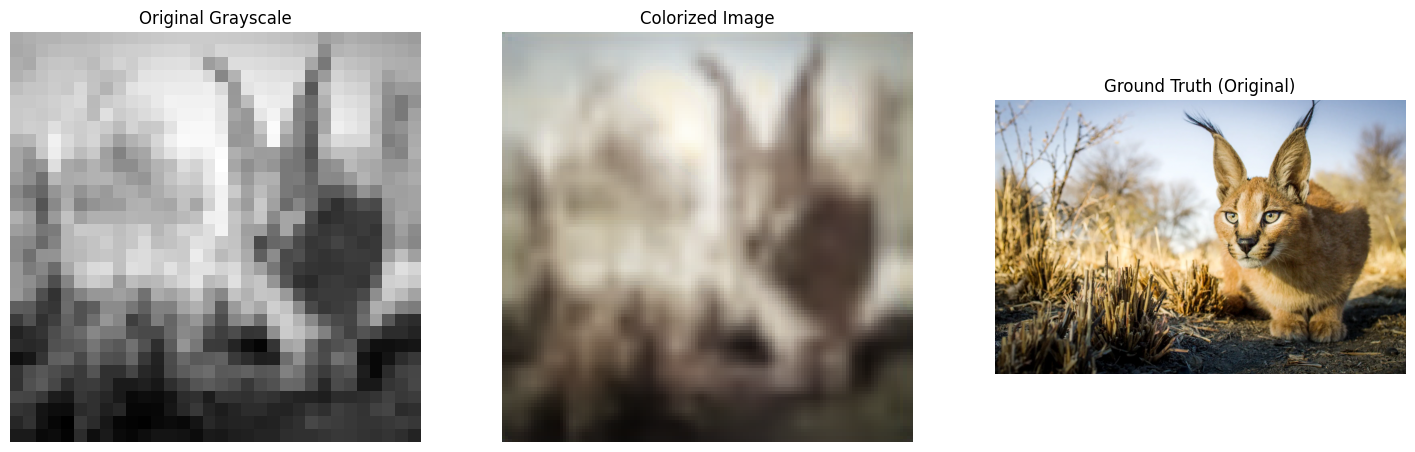

In [67]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# URL of the image
image_url = "https://c02.purpledshub.com/uploads/sites/62/2019/01/Cat-c6f5a79.jpg?w=1880&webp=1"

# Function to load and preprocess the image for model input
def load_and_preprocess_image(image_url, target_size=(32, 32)):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    image = image.resize(target_size)
    image = image.convert('L')  # Convert to grayscale
    image = np.array(image)
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to load the original image without resizing or converting to grayscale
def load_original_image(image_url):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    return image

# Load the grayscale image for model input
input_image = load_and_preprocess_image(image_url)

# Load the original image
original_image = load_original_image(image_url)

# Load the pre-trained model
model_path = '/content/drive/MyDrive/Colab Notebooks/cv/models/generator_epoch_99.keras'  # Adjust path as necessary
model = tf.keras.models.load_model(model_path)

# Predict the colorized image
predicted = model.predict(input_image)
predicted_image = np.clip(predicted[0], 0, 1)  # Clip values to valid range

# Plot the results
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(input_image[0]), cmap='gray')
plt.title('Original Grayscale')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predicted_image)
plt.title('Colorized Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(original_image)
plt.title('Ground Truth (Original)')
plt.axis('off')

plt.show()

The last traning of Generative Adversarial Network (GAN) model  over 100 epochs, focusing on two main aspects: the training losses for both the generator and discriminator, and the image quality metrics, specifically PSNR (Peak Signal-to-Noise Ratio) and SSIM (Structural Similarity Index).
### Training Losses Graph Analysis:
Generator Loss (Blue Line): The generator's loss starts relatively high and shows a significant decrease as training progresses. This indicates that the generator is improving its ability to create images that the discriminator classifies as real. The loss stabilizes towards the end of training, suggesting that the generator might be reaching a point of convergence.
Discriminator Loss (Red Line): The discriminator's loss also starts high but decreases sharply, showing more volatility compared to the generator loss. The frequent spikes in discriminator loss suggest that it is often fooled by the generator, especially in the early and middle stages of training. The loss decreases and stabilizes as the training progresses, which could indicate that the discriminator is becoming more adept at distinguishing between real and generated images.

### Image Quality Metrics Graph Analysis:
PSNR (Green Line): The PSNR starts at a high value and remains relatively stable throughout the training process. PSNR is a measure of the peak error between the generated and real images. The high and stable PSNR values suggest that the generated images maintain a consistent level of similarity to the real images in terms of pixel intensity.
SSIM (Purple Line): The SSIM starts very low and remains almost constant throughout the training. SSIM measures the perceptual difference between two similar images, which is sensitive to texture, structure, and luminance. The low SSIM values suggest that, despite the generator producing images with correct pixel intensities (as indicated by PSNR), the structural and textural similarity to the real images is not captured well.

### Overall Result :
The training losses indicate that both the generator and discriminator are improving over time, with the generator showing a more stable convergence compared to the discriminator.
The high PSNR values suggest that the generated images are close to the real images in terms of raw pixel values.
The low SSIM values are a concern as they indicate that the generated images, while close in raw pixel values, do not capture the structure, texture, or luminance of the real images effectively. This could mean that the images, while looking superficially similar to the desired outputs, lack the finer details and quality that would make them indistinguishable from real images.